In [1]:
import numpy as np
import utils.makeDataset as DatasetMaker
from utils.training import show_confusion_matrix, load_model_and_label_encoder, load_model
from sklearn.metrics import classification_report
import pickle

from matplotlib import pyplot as plt
import os

## Classification with validation data
### 1) Predictions of Qf (Q10, Q50 or Q90)

In [2]:
OUTPUT_DATA_FOLDER = '../output/datasets/'
INPUT_DATA_FOLDER = '../data/'

DATASETS = ["validation"]  # random Qf, d and roundings
BL_COMPUTE_AVG = False

              precision    recall  f1-score   support

         Q10       0.88      0.89      0.88        73
         Q50       0.88      0.86      0.87        59
         Q90       0.91      0.91      0.91        54

    accuracy                           0.89       186
   macro avg       0.89      0.89      0.89       186
weighted avg       0.89      0.89      0.89       186



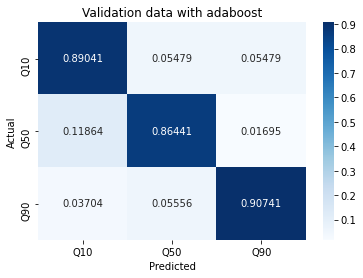

              precision    recall  f1-score   support

         Q10       0.88      0.89      0.88        73
         Q50       0.88      0.86      0.87        59
         Q90       0.91      0.91      0.91        54

    accuracy                           0.89       186
   macro avg       0.89      0.89      0.89       186
weighted avg       0.89      0.89      0.89       186



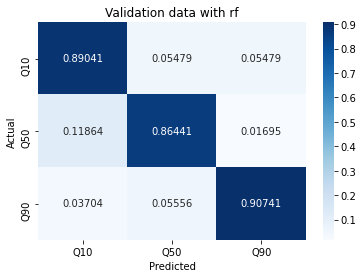

In [3]:
MODEL_TYPE = ["adaboost", "rf"]
for MODEL in MODEL_TYPE:
    PATH_MODELS = f"../models/final_models/Q/{MODEL}/"
    MODEL_NAME = f"{MODEL}_Q10_Q50_Q90"
    model_Q, label_encoder_Q = load_model_and_label_encoder(PATH_MODELS, MODEL_NAME)

    ground_truth, X_validation = DatasetMaker.load_dataset(DATASETS[0])
    y_true_Qf = label_encoder_Q.transform([f"Q{dict_settings['Q']}" for dict_settings in ground_truth])
    y_Qf_pred = model_Q.predict(X_validation)

    print(classification_report(y_true_Qf, y_Qf_pred, target_names=label_encoder_Q.classes_))
    show_confusion_matrix(y_true_Qf, y_Qf_pred, label_encoder_Q.classes_, f"Validation data with {MODEL}")

### 2) Prediction of the 1D-DCT function (d1, d2 or d3)

In [4]:
MODEL = "rf"
PATH_MODELS = "../models/final_models/"

MODEL_NAME_Q10 = f"{MODEL}_d1_Q10_d2_Q10_d3_Q10"
model_d_Q10 = load_model(os.path.join(PATH_MODELS, "d_Q10/"), MODEL_NAME_Q10)

MODEL_NAME_Q50 = f"{MODEL}_d1_Q50_d2_Q50_d3_Q50"
model_d_Q50 = load_model(os.path.join(PATH_MODELS, "d_Q50/"), MODEL_NAME_Q50)

MODEL_NAME_Q90 = f"{MODEL}_d1_Q90_d2_Q90_d3_Q90"
model_d_Q90 = load_model(os.path.join(PATH_MODELS, "d_Q90/"), MODEL_NAME_Q90)

ground_truth, X_validation = DatasetMaker.load_dataset(DATASETS[0])

In [5]:
with open(os.path.join(PATH_MODELS, f"LABEL_ENCODER_rf_d1_d2_d3.pickle"), 'rb') as handle:
    label_encoder_d = pickle.load(handle)

y_d_true = []
for element in ground_truth:
    if "function d1" in str(element["d"]):
        y_d_true.append(label_encoder_d.transform(['d1'])[0])
    elif "function d2" in str(element["d"]):
        y_d_true.append(label_encoder_d.transform(['d2'])[0])
    elif "function d3" in str(element["d"]):
        y_d_true.append(label_encoder_d.transform(['d3'])[0])

In [6]:
y_Qf_pred_labels = label_encoder_Q.inverse_transform(y_Qf_pred)

In [7]:
y_d_pred = []
for current_X, Q_pred in zip(X_validation, y_Qf_pred_labels):
    if Q_pred == "Q10":
        y_d_pred.append(model_d_Q10.predict(current_X.reshape(1, -1))[0])
    elif Q_pred == "Q50":
        y_d_pred.append(model_d_Q50.predict(current_X.reshape(1, -1))[0])
    elif Q_pred == "Q90":
        y_d_pred.append(model_d_Q90.predict(current_X.reshape(1, -1))[0])

              precision    recall  f1-score   support

          d1       0.89      0.88      0.88        73
          d2       0.88      0.88      0.88        66
          d3       0.85      0.87      0.86        47

    accuracy                           0.88       186
   macro avg       0.87      0.88      0.87       186
weighted avg       0.88      0.88      0.88       186



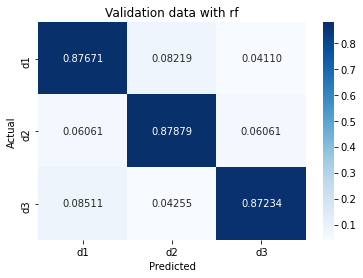

In [8]:
print(classification_report(y_d_true, y_d_pred, target_names=["d1", "d2", "d3"]))
show_confusion_matrix(y_d_true, y_d_pred, label_encoder_d.classes_, f"Validation data with {MODEL}")

In [9]:
y_true_multiclass = []
for q, d in zip(y_true_Qf, y_d_true):
    y_true_multiclass.append([q, d])

y_pred_multiclass = []
for q, d in zip(y_Qf_pred, y_d_pred):
    y_pred_multiclass.append([q, d])

In [10]:
y_true_multiclass = np.array(y_true_multiclass)
y_pred_multiclass = np.array(y_pred_multiclass)

well_predicted_Q = np.sum(np.equal(y_true_multiclass[:, 0], y_pred_multiclass[:, 0])) / float(y_true_multiclass.shape[0])
print(f"Amount images with well predicted Q : {well_predicted_Q * 100}%\n")

well_predicted_d = np.sum(np.equal(y_true_multiclass[:, 1], y_pred_multiclass[:, 1])) / float(y_true_multiclass.shape[0])
print(f"Amount images with well predicted d : {well_predicted_d * 100}%\n")

good_Q_and_d_number = len([element for element in y_true_multiclass == y_pred_multiclass if (element[0] and element[1])])
well_predicted_Q_and_d = good_Q_and_d_number / float(y_true_multiclass.shape[0])
print(f"Amount images with well predicted Q and d : {well_predicted_Q_and_d * 100}%\n")

Amount images with well predicted Q : 88.70967741935483%

Amount images with well predicted d : 87.63440860215054%

Amount images with well predicted Q and d : 83.33333333333334%



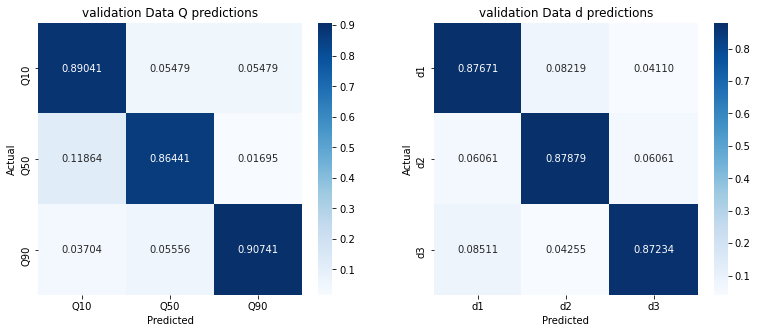

In [11]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
show_confusion_matrix(y_true_multiclass[:, 0], y_pred_multiclass[:, 0], label_encoder_Q.classes_,
                      "validation Data Q predictions", False)
plt.subplot(122)
show_confusion_matrix(y_true_multiclass[:, 1], y_pred_multiclass[:, 1], label_encoder_d.classes_,
                      "validation Data d predictions", False)
plt.show()

In [16]:
def convert_multi_label_to_single(y_multilabel):
    new_y = []
    for q, d in y_multilabel:
        new_class = None
        if q == 0 and d == 0:
         new_class = 0
        if q == 0 and d == 1:
         new_class = 1
        if q == 0 and d == 2:
         new_class = 2

        if q == 1 and d == 0:
         new_class = 3
        if q == 1 and d == 1:
         new_class = 4
        if q == 1 and d == 2:
         new_class = 5

        if q == 2 and d == 0:
         new_class = 6
        if q == 2 and d == 1:
         new_class = 7
        if q == 2 and d == 2:
         new_class = 8

        new_y.append(new_class)
    return np.array(new_y)

In [17]:
classes = ["Q1_d1", "Q1_d2", "Q1_d3", "Q2_d1", "Q2_d2", "Q2_d3", "Q3_d1", "Q3_d2", "Q3_d3"]
y_true_single_label = convert_multi_label_to_single(y_true_multiclass)
y_pred_single_label = convert_multi_label_to_single(y_pred_multiclass)

              precision    recall  f1-score   support

       Q1_d1       0.78      0.78      0.78        27
       Q1_d2       0.77      0.79      0.78        29
       Q1_d3       0.82      0.82      0.82        17
       Q2_d1       0.77      0.74      0.76        23
       Q2_d2       1.00      1.00      1.00        14
       Q2_d3       0.82      0.82      0.82        22
       Q3_d1       0.91      0.91      0.91        23
       Q3_d2       0.91      0.87      0.89        23
       Q3_d3       0.78      0.88      0.82         8

    accuracy                           0.83       186
   macro avg       0.84      0.85      0.84       186
weighted avg       0.83      0.83      0.83       186



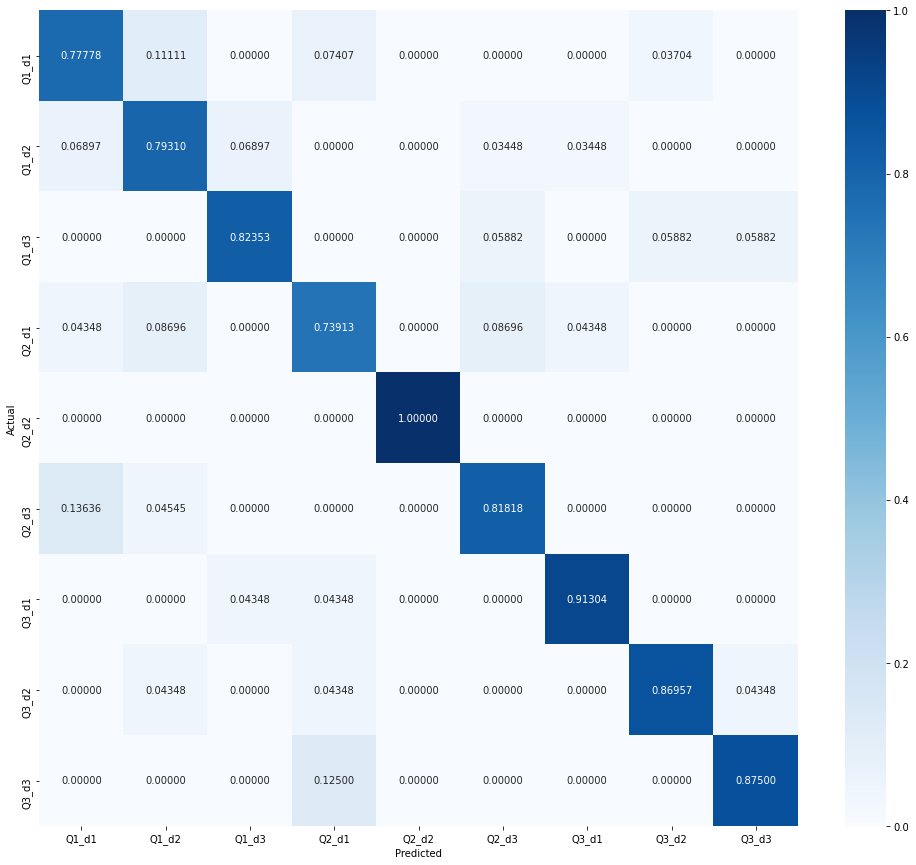

In [23]:
print(classification_report(y_true_single_label, y_pred_single_label, target_names=classes))
plt.figure(figsize=(17,15))
show_confusion_matrix(y_true_single_label, y_pred_single_label, classes, "", False)
plt.show()

